In [ ]:
 
%%capture
import pandas as pd
import numpy as np
# install ta-lib
!wget http://prdownloads.sourceforge.net/ta-lib/ta-lib-0.4.0-src.tar.gz
!tar -xzvf ta-lib-0.4.0-src.tar.gz
%cd ta-lib
!./configure --prefix=/usr
!make
!make install
!pip install Ta-Lib
print('TA Lib installed.')
 
import datetime as dt
import pickle
import statsmodels.api as sm
 
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.model_selection import train_test_split
import talib
 
 
%matplotlib inline
plt.style.use('seaborn-white')
!pip install yfinance
import yfinance as yf
print('Yahoo Finance installed.')
 
!pip install backtrader
import backtrader as bt
!pip install psaw
from psaw import PushshiftAPI
print('Pushshift installed.')
 
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
 
import os
import re
import numpy as np
import pandas as pd
 
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Flatten, Dense
from tensorflow.keras.utils import plot_model
 
from IPython.display import display, clear_output

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive',force_remount=True)
!pwd

Mounted at /content/gdrive
/content/ta-lib


In [ ]:
%cd ..
%cd gdrive/MyDrive
!pwd

/content
/content/gdrive/MyDrive
/content/gdrive/MyDrive


In [ ]:
# Insert the directory
import sys
sys.path.insert(0,'/content/gdrive/MyDrive/FINEDEC/')
import preprocess
from string import punctuation

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


In [ ]:
# USEFUL FUNCTIONS #

# Wrapper function for candlesticks from yahoo finance
def adj_ohlcv(hist_ohlcv):
  # Use adjusted close to work out intraday prices, change volume to $ turnover
  adj_px = hist_ohlcv['Adj Close'] - hist_ohlcv['Close']
  adj_ohlcv = hist_ohlcv[['Open','High','Low','Close']].add(adj_px,axis=0)
  adj_ohlcv['Volume'] = hist_ohlcv['Close'] * hist_ohlcv['Volume']
  return adj_ohlcv

# Normalizer
def calc_z(x, t):
  return (x - x.rolling(t).mean()) / x.rolling(t).std()

# Calculate Money Flow Index using candlesticks with volume
def calc_mfi(ohlcv,t):
  return talib.MFI(ohlcv.High, ohlcv.Low, ohlcv.Close, ohlcv.Volume, timeperiod=t)

In [ ]:
!pwd

/content/gdrive/MyDrive


In [ ]:
resid_tweets = pd.read_csv('FINEDEC/resid_tweets.csv')
resid_tweets['date'] = [dt.datetime.strptime(i,'%Y-%m-%d') for i in resid_tweets.date]
resid_tweets['body'] = resid_tweets.body.astype(str)

In [ ]:
resid_tweets[['body','date','stk','ret','beta','bench_return','resid_return']].head(10)

,body,date,stk,ret,beta,bench_return,resid_return
0,jeff worst bezos billion year lost since,2015-01-01,AMZN,-0.012989,0.784360,-0.004603,-0.009378
1,earlier suddenly caused via month drop glitch ...,2015-01-01,AAPL,-0.018494,1.043523,-0.004603,-0.013690
2,company term tech diversity rank like see,2015-01-01,FB,-0.001654,1.114565,-0.004603,0.003476
3,company term tech diversity rank like see,2015-01-01,AAPL,-0.018494,1.043523,-0.004603,-0.013690
4,hint street pick wall top,2015-01-01,GOOGL,-0.005727,0.907207,-0.004603,-0.001551
5,hint street pick wall top,2015-01-01,AAPL,-0.018494,1.043523,-0.004603,-0.013690
6,market underperformed likely street year wall ...,2015-01-02,AAPL,-0.018838,1.043523,-0.012000,-0.006316
7,boon free investor cost holiday high delivery ...,2015-01-02,AMZN,-0.015700,0.784360,-0.012000,-0.006288
8,boon free investor cost holiday high delivery ...,2015-01-02,WMT,-0.000817,0.508070,-0.012000,0.005280
9,boon free investor cost holiday high delivery ...,2015-01-02,TGT,-0.015831,0.696950,-0.012000,-0.007467


In [ ]:
test_stk = 'AMZN'
train_resid_tweets = resid_tweets[resid_tweets.stk != test_stk].copy()

In [ ]:
# define input_x, input_y
train_stk = train_resid_tweets['stk'].unique()
train_df = train_resid_tweets[train_resid_tweets.stk.isin(train_stk)]
train_text = train_df['body'].values
train_return = np.where(train_df['resid_return'] > 0, 1, 0)

max_words = 10000 
tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_text)

word_index = tokenizer.word_index
print('Found %s unique tokens but will only consider the top frequent %s words' %(len(word_index), max_words))

# convert the words to a seqence of numbers (index by the top frequency of the words)
# The words in the text sequence will be indexed as a number by the word_index
sequences = tokenizer.texts_to_sequences(train_text)

# Term frequency vector
df_wordIndex = pd.DataFrame.from_dict(word_index, orient='index', columns=['number'])[:max_words]
df_wordIndex.head(5)

Found 6796 unique tokens but will only consider the top frequent 10000 words


,number
stock,1
live,2
watch,3
say,4
today,5


In [ ]:
maxlen = 40 
data = pad_sequences(sequences, maxlen=maxlen)
labels = train_return

print('Shape of data tensor', data.shape)
print('Shape of labels tensor', labels.shape)

Shape of data tensor (10455, 40)
Shape of labels tensor (10455,)


In [ ]:
# Tweet vector
data[0]

array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,  950,
       1894, 2156,   10,  176,   52, 1895, 4297], dtype=int32)

In [ ]:
from sklearn.model_selection import train_test_split
X = data
y = train_return
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42,shuffle=True)

print("x_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("x_val shape:", X_val.shape)
print("y_val shape:", y_val.shape)
print("x_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

x_train shape: (6273, 40)
y_train shape: (6273,)
x_val shape: (2091, 40)
y_val shape: (2091,)
x_test shape: (2091, 40)
y_test shape: (2091,)


In [ ]:
# The key idea here is to use word2vec (a pretrained vector which understand the text to certain extends) 
# to solve the 2nd issue (text understanding) and helps the neural network to learn the input/output mappings.
# Also, the word2vec output is a vector and which is exactly the required format for Neural Network

from gensim.models import word2vec

tweets = [tweet.split(' ') for tweet in train_resid_tweets['body']]
w2vModel = word2vec.Word2Vec(tweets, window=5)
w2v = w2vModel.wv

print("No.of words in the vocab:", len(w2v.vocab))

No.of words in the vocab: 2155


In [ ]:
w2v.most_similar('street')

[('estimate', 0.9966078400611877),
 ('saying', 0.996589183807373),
 ('pace', 0.9964562654495239),
 ('bull', 0.9963369369506836),
 ('amid', 0.9963318109512329),
 ('starting', 0.9963303208351135),
 ('volatility', 0.9963126182556152),
 ('get', 0.9962913990020752),
 ('master', 0.996241569519043),
 ('operating', 0.9961831569671631)]

In [ ]:
# Note that the index 0 is not supposed to stand for any word or token -- it's a placeholder.
# The Embedding layer a matrix of shape (max_words, embedding_dim), 

embedding_dim = w2v.vector_size
embedding_matrix = np.zeros((max_words, embedding_dim))

for word, i in word_index.items():
  # Words not found in embedding index will be all-zeros.
  if word in w2v.vocab and i < max_words:
    embedding_matrix[i] = w2v[word]

print("embedding_matrix.shape:", embedding_matrix.shape)

embedding_matrix.shape: (10000, 100)


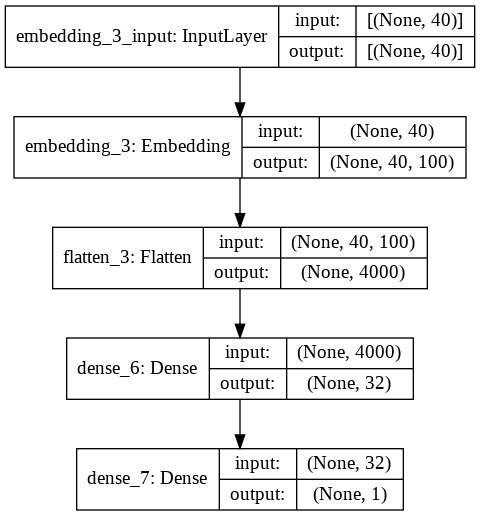

In [ ]:
w2vModel = Sequential()

# Use w2v embedding layer to injects "pre-trained" language knowledge 
# to encode (represent) the input data more meaningfully
# It is a type of transfer learning 
w2vModel.add(Embedding(max_words, embedding_dim, input_length=maxlen))

# Then flatten the embedding output to a single vector for the hidden Dense layer 
# flatten the 200 sequence of 300-dim w2v vector into one single vector for dense layer
w2vModel.add(Flatten())
w2vModel.add(Dense(32, activation='relu'))
w2vModel.add(Dense(1, activation='sigmoid'))

plot_model(w2vModel, show_shapes=True, show_layer_names=True)

In [ ]:
# Load the Embedding layer from the embedding_matrix and no need to train the parameters 

w2vModel.layers[0].set_weights([embedding_matrix])
w2vModel.layers[0].trainable = False
w2vModel.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 40, 100)           1000000   
_________________________________________________________________
flatten_3 (Flatten)          (None, 4000)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 32)                128032    
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 33        
Total params: 1,128,065
Trainable params: 128,065
Non-trainable params: 1,000,000
_________________________________________________________________


Epoch 1/20
99/99 [==============================] - 1s 6ms/step - loss: 0.6960 - accuracy: 0.5131 - val_loss: 0.6932 - val_accuracy: 0.4873
Epoch 2/20
99/99 [==============================] - 0s 4ms/step - loss: 0.6929 - accuracy: 0.5204 - val_loss: 0.6934 - val_accuracy: 0.4969
Epoch 3/20
99/99 [==============================] - 0s 5ms/step - loss: 0.6916 - accuracy: 0.5234 - val_loss: 0.6935 - val_accuracy: 0.4955
Epoch 4/20
99/99 [==============================] - 0s 5ms/step - loss: 0.6922 - accuracy: 0.5023 - val_loss: 0.6933 - val_accuracy: 0.5045
Epoch 5/20
99/99 [==============================] - 0s 5ms/step - loss: 0.6907 - accuracy: 0.5105 - val_loss: 0.6930 - val_accuracy: 0.4912
Epoch 6/20
99/99 [==============================] - 0s 5ms/step - loss: 0.6899 - accuracy: 0.5073 - val_loss: 0.6934 - val_accuracy: 0.4935
Epoch 7/20
99/99 [==============================] - 0s 4ms/step - loss: 0.6894 - accuracy: 0.5275 - val_loss: 0.6956 - val_accuracy: 0.4921
Epoch 8/20
99/99 [==

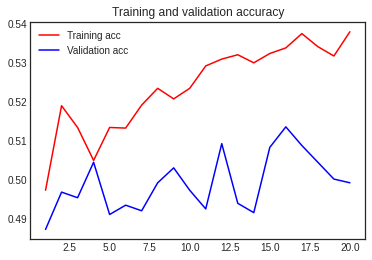

In [ ]:
# compile the model after setting the Embedding layer to non-trainable
w2vModel.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

history = w2vModel.fit(X_train, y_train,
                    epochs=20,
                    batch_size=64,
                    validation_data=(X_val, y_val))

# Plot the accuracy
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.show()

In [ ]:
# Do the prediction on the test set
score = w2vModel.evaluate(X_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

ans = w2vModel.predict(X_test)

Test loss: 0.702043354511261
Test accuracy: 0.4964132010936737


In [ ]:
# MFI Strategy, be long when MFI > 50, but not overbought, unwind if MFI < 50 or > overbought level
test_stk = 'AMZN'

MFI_PERIOD = 30
MFI_OVERBOUGHT = 70
MFI_UPTREND = 50

start_date = resid_tweets[resid_tweets.stk == test_stk].date.min() - dt.timedelta(180)
end_date = resid_tweets[resid_tweets.stk == test_stk].date.max() + dt.timedelta(30)

stk_ohlcv = adj_ohlcv(yf.download(test_stk,start_date,end_date))
stk_mfi = pd.DataFrame(talib.MFI(stk_ohlcv.High,stk_ohlcv.Low,stk_ohlcv.Close,stk_ohlcv.Volume, MFI_PERIOD),columns=['mfi'])
stk_mfi['mfi_pos'] = np.where((stk_mfi.mfi > MFI_UPTREND) & (stk_mfi.mfi < MFI_OVERBOUGHT), 1, 0)

# Tweet sentiment signal
test_tweets = resid_tweets[resid_tweets.stk == test_stk].copy()
test_sequences = tokenizer.texts_to_sequences(test_tweets['body'].values)
maxlen = 40 
test_data = pad_sequences(test_sequences, maxlen=maxlen)

tweet_sentiment = pd.DataFrame(w2vModel.predict(test_data),test_tweets.date,columns=['w2v_sentiment'])
buy_signal = stk_mfi[['mfi_pos']].join(tweet_sentiment.groupby(tweet_sentiment.index.date).mean(),how='outer').fillna(method='ffill').dropna()
buy_signal['signal'] = np.where((buy_signal.mfi_pos == 1) & (buy_signal.w2v_sentiment > 0.5),1,0)

# Backtest Strategies
backtest = stk_ohlcv.pct_change().shift(-1).copy()
backtest['mfi_pos'] = stk_mfi['mfi_pos']
backtest['senti_pos'] = buy_signal.signal
backtest['combo_ret'] = backtest.senti_pos * backtest.Close
backtest['mfi_ret'] = backtest.mfi_pos * backtest.Close
backtest.dropna(inplace=True)

# Calculate Monthly Returns
cum_backtest = pd.DataFrame(np.cumprod(1 + backtest['combo_ret'].values) - 1, backtest.index, columns=['combo'])
cum_backtest['mfi'] = np.cumprod(1 + backtest['mfi_ret'].values) - 1
cum_backtest['buy_and_hold'] = np.cumprod(1 + backtest['Close'].values) - 1
#plt.figure(figsize=(12,3))
#cum_backtest.plot(title=test_stk+' Backtest Results')

backtest_monthly = cum_backtest.groupby([cum_backtest.index.year,cum_backtest.index.month])
monthly_ret = backtest_monthly.last() - backtest_monthly.first()
sharpe = (monthly_ret.mean() / monthly_ret.std()) * np.sqrt(12)
print('Sharpe Ratio')
print(sharpe)

gain2pain = []
for s in cum_backtest.columns:
  gain2pain.append(monthly_ret[s][monthly_ret[s] > 0].mean() / np.abs(monthly_ret[s][monthly_ret[s] < 0].mean()))
g2p = pd.DataFrame(gain2pain,cum_backtest.columns,columns=['gain2pain'])
print('Monthly Gain-to-Pain Ratio')
print(g2p)
print(monthly_ret.describe())

[*********************100%***********************]  1 of 1 completed
Sharpe Ratio
combo           1.626245
mfi             1.171313
buy_and_hold    1.086955
dtype: float64
Monthly Gain-to-Pain Ratio
              gain2pain
combo          2.414627
mfi            1.124079
buy_and_hold   1.056908
           combo        mfi  buy_and_hold
count  61.000000  61.000000     61.000000
mean    0.061370   0.053293      0.091086
std     0.130725   0.157611      0.290288
min    -0.167645  -0.249058     -0.991119
25%    -0.004993  -0.009456     -0.046512
50%     0.013549   0.029139      0.124530
75%     0.124569   0.142466      0.243647
max     0.546707   0.515211      0.665046


<Figure size 432x288 with 0 Axes>

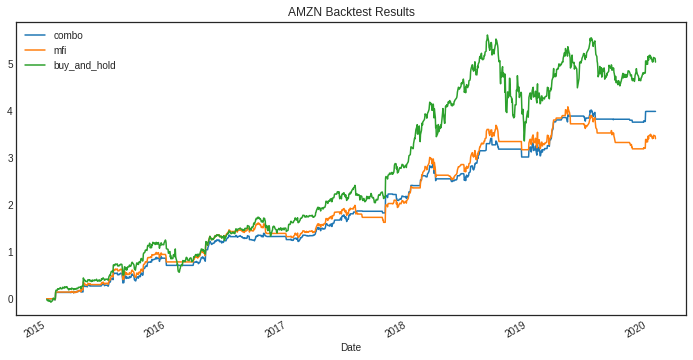

<Figure size 432x288 with 0 Axes>

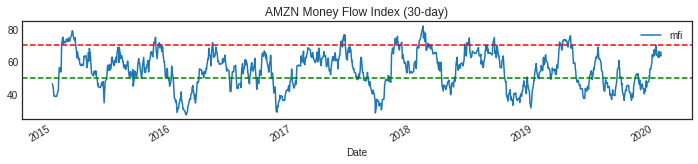

<Figure size 432x288 with 0 Axes>

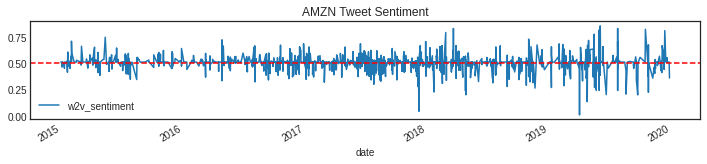

In [ ]:
plt.figure()
cum_backtest.plot(figsize=(12,6),title=test_stk+' Backtest Results')
plt.show()

plt.figure()
stk_mfi[['mfi']].loc[cum_backtest.index].dropna().plot(figsize=(12,2),title=test_stk+' Money Flow Index ('+str(int(MFI_PERIOD))+'-day)')
plt.axhline(y=MFI_UPTREND,linestyle='--',color='g')
plt.axhline(y=MFI_OVERBOUGHT,linestyle='--',color='r')
plt.show()

plt.figure()
tweet_sentiment[tweet_sentiment.index.isin(cum_backtest.index)].dropna().plot(figsize=(12,2),title=test_stk+' Tweet Sentiment')
plt.axhline(y=0.5,linestyle='--',color='r')
plt.show()

**CONCLUSION**
The word2vec model on tweets was not that accurate, but we can see from a risk-adjusted perspective that combining a simple systematic strategy based on technical indicators could possibly be improved by combining it with a Tweet sentiment signal. 

I would work on improving this strategy by separating it into modules:
1. NLP Sentiment model - research how to optimise the model and potentially datasets
2. Technical strategy - optimise parameters or modify for regime switching
3. Sentiment signal - engineer and try different methods of using it to time executions